# Visualization Guide

A guide to use the visualization capabilities in the `ocd.visualization` folder.

In [2]:
import sys
sys.path.append('../')
import torch
import matplotlib.pyplot as plt
from notebook_setup import device, smooth_graph, create_new_set_of_models, train_models_and_get_histories, update_dict
from ocd.models.oslow import OSlow
from ocd.data.synthetic.graph_generator import GraphGenerator
from ocd.data.synthetic.utils import RandomGenerator
from ocd.data.synthetic.parametric import AffineParametericDataset
from ocd.data.synthetic.nonparametric import AffineNonParametericDataset
from ocd.models.normalization import ActNorm
from tqdm import tqdm
import numpy as np

%load_ext autoreload
%autoreload 2
print(device)


cuda


## Training

Basic training of a parametric sinusoidal dataset:

In [8]:

graph_generator = GraphGenerator(
    num_nodes=3,
    seed=0,
    graph_type="full",
    enforce_ordering=[1, 0, 2],
)
graph = graph_generator.generate_dag()

# These generators are also needed to generate the data
gaussian_noise_generator = RandomGenerator('normal', seed=10, loc=0, scale=1)
link_generator = RandomGenerator('uniform', seed=110, low=1, high=1)

num_samples = 10000
# parameteric with sin(x) + x non-linearity and softplus
dset = AffineParametericDataset(
    num_samples=num_samples,
    graph=graph,
    noise_generator=gaussian_noise_generator,
    link_generator=link_generator,
    link="sinusoid",
    perform_normalization=False,
)


base_model_instantiation_setting = dict(
    additive = False,
    num_transforms = 1,
    normalization = ActNorm,
    base_distribution = torch.distributions.Normal(loc=0, scale=1),
    use_standard_ordering=True,
)

base_training_setting = dict(
)

model = create_new_set_of_models(
    additive = False,
    num_transforms = 1,
    normalization = ActNorm,
    base_distribution = torch.distributions.Normal(loc=0, scale=1),
    use_standard_ordering=True,
    single_ordering = '012',
)

train_models_and_get_histories(
    dset=dset,
    all_models={'012': model},
    batch_size=256, 
    lr=0.005, 
    epoch_count=33,
    use_standard_ordering=True,
)

model.eval()

training model 012: 100%|██████████| 33/33 [00:23<00:00,  1.38it/s]


OSlow(
  (0): MaskedAffineFlowTransform(
    (masked_mlp_shift): MaskedMLP(
      (0): MaskedBlock(
        in_features=3, out_features=300, bias=True
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (1): MaskedBlock(
        in_features=300, out_features=300, bias=True
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (2): MaskedBlock(in_features=300, out_features=3, bias=True)
    )
    (masked_mlp_scale): MaskedMLP(
      (0): MaskedBlock(
        in_features=3, out_features=300, bias=True
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (1): MaskedBlock(
        in_features=300, out_features=300, bias=True
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (2): MaskedBlock(
        in_features=300, out_features=3, bias=True
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (3): MaskedBlock(in_features=3, out_features=3, bias=True)
    )
    (normalization): ActNorm()
  )
)

## Visualizing Data Marginals with QQ-Plots

We can visualize how the marginals of the datasets look like using the `plot_marginals` function

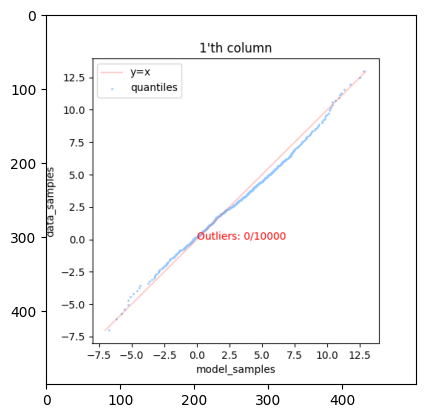

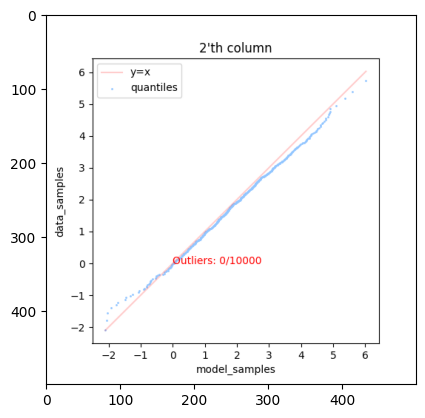

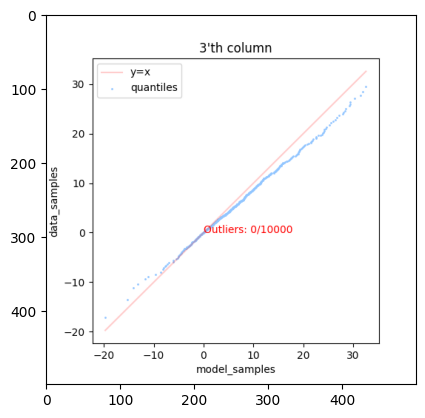

In [12]:
%autoreload 2
from ocd.visualization.qqplot import qqplot
import torch

num_samples = 1000

model_samples = model.sample(num_samples)
data_samples = torch.from_numpy(dset.samples.values)
all_marginals = qqplot(
    model_samples = model_samples, 
    data_samples = data_samples,
    reject_outliers_factor = 3.0, 
    quantile_count = 555,
    image_size = (5, 5),
)
for i in range(len(all_marginals)):
    plt.imshow(all_marginals[i])
    plt.show()

## Visualizing the Permutation Model

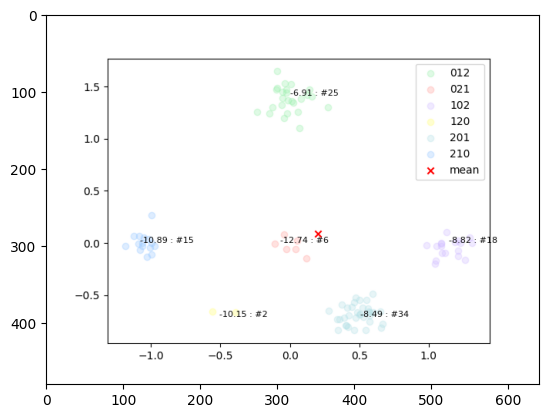

In [47]:
%autoreload 2
from ocd.training.trainer import PermutationLearningModule
from ocd.visualization.birkhoff import visualize_birkhoff_polytope

permutation_model = PermutationLearningModule(3)

img = visualize_birkhoff_polytope(
    permutation_model=permutation_model,
    num_samples=100,
    data=torch.from_numpy(dset.samples.values[:100]),
    flow_model=model,
)
plt.imshow(img)
plt.show()